## Introduction



Memory judgments in item recognition tests can be influenced by familiarity-based processes like processing fluency. While traditional accounts of source memory suggest minimal impact of familiarity, recent work indicates that source memory judgments can be affected when test stimuli are processed with greater fluency due to priming. The experiments in this paper investigated the relationship between fluency and the accuracy of source memory decisions.   

This analysis reproduces the findings from Experiment 1 of Huang and Shanks (2021), which aimed to investigate how fluency relates to source memory responses, including the more commonly used R/K or R/K/G responses. Another goal was to address the lack of research on memory involving multiple source attributes crossed at encoding and jointly retrieved. Participants studied words presented with different source attributes (font size and location). During testing, they identified words that clarified on screen through progressive demasking (CID-R task), made old/new and source memory judgments, and provided confidence ratings. Identification response times (RTs) from the item identification task were used as a measure of fluency.

## Result

In [578]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg

Load the dataset and perform data preprocessing

In [584]:
# Load the data
data = pl.read_csv("E:\PhD sem 2\PSYCH Data analysis\datascipsych_finalproject\src\project\data\data_expt1.csv")
df = data.to_pandas()

# Create milliseconds column
df["idRespTime_ms"] = df["idRespTime"] * 1000

# Create source correctness columns
df["size_correct"] = np.where(
    ((df["SourceSizeResp"] > 0) & (df["SourceEncodingSize"] == "large")) | 
    ((df["SourceSizeResp"] < 0) & (df["SourceEncodingSize"] == "small")),
    1, 0
)

df["loc_correct"] = np.where(
    ((df["SourceLocResp"] > 0) & (df["SourceEncodingLoc"] == "upper")) | 
    ((df["SourceLocResp"] < 0) & (df["SourceEncodingLoc"] == "lower")),
    1, 0
)

# Count total correct sources
df["correct_sources"] = df["size_correct"] + df["loc_correct"]

df.head(5)

,Subject,Subj/Trial Number,TestTrialNum,Stimuli,idRespTime,ItemRecognResp,SourceSizeResp,SourceLocResp,ItemStatus,OldNewItemResp,ItemRecogStatus,SourceEncodingSize,SourceEncodingLoc,SourceConfidence_absSum,SourceCorrect,idRespTime_ms,size_correct,loc_correct,correct_sources
0,P01,P01_10,10,tank,1.847444,Guess,0.0,0.0,lure,old,FalseAlarm,None,None,0.0,NaN,1847.443705,0,0,0
1,P01,P01_100,100,lace,1.430649,Know,3.0,3.0,target,old,Hit,small,upper,6.0,1.0,1430.648669,0,1,1
2,P01,P01_101,101,newt,1.847070,Guess,1.0,1.0,lure,old,FalseAlarm,None,None,2.0,NaN,1847.070295,0,0,0
3,P01,P01_102,102,kick,0.863761,Remember,4.0,4.0,target,old,Hit,small,lower,8.0,0.0,863.761488,0,0,0
4,P01,P01_103,103,quart,1.147339,New,NaN,NaN,lure,old,CorrectRej,None,None,NaN,NaN,1147.339108,0,0,0


Calculate hit rate and false alarm rate

In [585]:
# Calculate hit rate
total_targets = df[df['ItemStatus'] == 'target'].shape[0]
hits = df[(df['ItemStatus'] == 'target') & (df['ItemRecogStatus'] == 'Hit')].shape[0]
hit_rate = hits / total_targets

# Calculate false alarm rate
total_lures = df[df['ItemStatus'] == 'lure'].shape[0]
false_alarms = df[(df['ItemStatus'] == 'lure') & (df['ItemRecogStatus'] == 'FalseAlarm')].shape[0]
fa_rate = false_alarms / total_lures

print(f"Hit rate: {hit_rate:.2f}")
print(f"False alarm rate: {fa_rate:.2f}")

Hit rate: 0.80
False alarm rate: 0.25


Hit rate and False alarm matched the paper. Test trials receiving R, K and G were considered as ‘old’ responses. Across all valid test trials, the hit rate
 was 0.80 and the false alarm rate was 0.25.

### Recognition Memory Analysis

In [586]:
recognition_stats = df.groupby('ItemRecogStatus')['idRespTime'].agg([
    ('Mean', 'mean'), 
    ('SEM', lambda x: stats.sem(x)),
    ('Count', 'count')
])

print("\nRecognition category RT statistics:")
print(recognition_stats)

# Analyze Remember/Know/Guess responses
hit_trials = df[df['ItemRecogStatus'] == 'Hit'] # Filter for hit trials only

# Calculate RT for different response types
rkg_stats = hit_trials.groupby('ItemRecognResp')['idRespTime'].agg([
    ('Mean', 'mean'), 
    ('SEM', lambda x: stats.sem(x)),
    ('Count', 'count')
])

print("\nRemember/Know/Guess RT statistics:")
print(rkg_stats)

# Conduct t-tests comparing R vs K and K vs G
r_data = hit_trials[hit_trials['ItemRecognResp'] == 'Remember']['idRespTime']
k_data = hit_trials[hit_trials['ItemRecognResp'] == 'Know']['idRespTime']
g_data = hit_trials[hit_trials['ItemRecognResp'] == 'Guess']['idRespTime']

# R vs K t-test
tstat_rk, p_rk = stats.ttest_ind(r_data, k_data, equal_var=False)
print(f"\nRemember vs Know t-test: t={tstat_rk:.3f}, p={p_rk:.5f}")

# K vs G t-test
tstat_kg, p_kg = stats.ttest_ind(k_data, g_data, equal_var=False)
print(f"Know vs Guess t-test: t={tstat_kg:.3f}, p={p_kg:.5f}")


Recognition category RT statistics:
                     Mean       SEM  Count
ItemRecogStatus                           
CorrectRej       1.832874  0.014504   2115
FalseAlarm       1.759771  0.023051    721
Hit              1.553917  0.012919   2329
Miss             1.647540  0.028337    597

Remember/Know/Guess RT statistics:
                    Mean       SEM  Count
ItemRecognResp                           
Guess           1.698862  0.037533    334
Know            1.597163  0.026807    564
Remember        1.503042  0.015759   1431

Remember vs Know t-test: t=-3.027, p=0.00254
Know vs Guess t-test: t=-2.205, p=0.02780


As memory retrieval becomes less detailed (from Remember to Know to Guess responses), the response times progressively increase, with statistically significant differences between each category. The paper’s hypothesis is supported that processing fluency is closely linked to the subjective experience of remembering, suggesting that memory recall is not a binary process but exists on a continuous spectrum of retrieval detail and ease.

### Source Memory Analysis

In [581]:
source_accuracy_stats = hit_trials.groupby('correct_sources')['idRespTime_ms'].agg([
    ('Mean', 'mean'), 
    ('SEM', lambda x: stats.sem(x)),
    ('Count', 'count')
])

print("Source accuracy RT statistics:")
print(source_accuracy_stats)

# Conduct t-tests for source accuracy comparisons
# Compare 2 vs 0 correct sources
sources_2 = hit_trials[hit_trials['correct_sources'] == 2]['idRespTime_ms']
sources_1 = hit_trials[hit_trials['correct_sources'] == 1]['idRespTime_ms']
sources_0 = hit_trials[hit_trials['correct_sources'] == 0]['idRespTime_ms']

# 2 vs 0 sources t-test
tstat_20, p_20 = stats.ttest_ind(sources_2, sources_0, equal_var=False)
print(f"\n2 vs 0 sources t-test: t={tstat_20:.3f}, p={p_20:.5f}")

# 1 vs 0 sources t-test
tstat_10, p_10 = stats.ttest_ind(sources_1, sources_0, equal_var=False)
print(f"1 vs 0 sources t-test: t={tstat_10:.3f}, p={p_10:.5f}")

# 2 vs 1 sources t-test
tstat_21, p_21 = stats.ttest_ind(sources_2, sources_1, equal_var=False)
print(f"2 vs 1 sources t-test: t={tstat_21:.3f}, p={p_21:.5f}")

# Calculate correlation between R/K/G and source accuracy
rkg_mapping = {'Remember': 3, 'Know': 2, 'Guess': 1}
rkg_trials = hit_trials[hit_trials['ItemRecognResp'].isin(['Remember', 'Know', 'Guess'])].copy()
rkg_trials['rkg_numeric'] = rkg_trials['ItemRecognResp'].map(rkg_mapping)

# Compute correlation for each participant
correlations = []
subjects = rkg_trials['Subject'].unique()

for subject in subjects:
    subject_data = rkg_trials[rkg_trials['Subject'] == subject]
    if len(subject_data['rkg_numeric'].unique()) >= 2 and len(subject_data['correct_sources'].unique()) >= 2:
        r, p = stats.spearmanr(subject_data['rkg_numeric'], subject_data['correct_sources'])
        correlations.append(r)

# Calculate statistics on correlations
if correlations:
    mean_corr = np.mean(correlations)
    sem_corr = stats.sem(correlations)
    t_value = mean_corr / sem_corr
    p_value = 2 * (1 - stats.t.cdf(abs(t_value), len(correlations) - 1))
    
    positive = sum(r >= 0.10 for r in correlations)
    weak_positive = sum(0 < r < 0.10 for r in correlations)
    negative = sum(r <= 0 for r in correlations)
    
    print("\nR/K/G and source accuracy correlation:")
    print(f"Mean correlation: {mean_corr:.3f}")
    print(f"Standard error: {sem_corr:.3f}")
    print(f"t-value: {t_value:.3f}, p-value: {p_value:.5f}")
    print(f"Positive correlations (r >= 0.10): {positive}")
    print(f"Weak positive correlations (0 < r < 0.10): {weak_positive}")
    print(f"Negative correlations (r <= 0): {negative}")

Source accuracy RT statistics:
                        Mean        SEM  Count
correct_sources                               
0                1623.665007  22.407504    880
1                1530.643140  20.508938    775
2                1489.613564  23.788363    674

2 vs 0 sources t-test: t=-4.102, p=0.00004
1 vs 0 sources t-test: t=-3.062, p=0.00223
2 vs 1 sources t-test: t=-1.306, p=0.19166

R/K/G and source accuracy correlation:
Mean correlation: 0.307
Standard error: 0.032
t-value: 9.713, p-value: 0.00000
Positive correlations (r >= 0.10): 38
Weak positive correlations (0 < r < 0.10): 3
Negative correlations (r <= 0): 5


This result supports the paper's hypothesis that identification RTs are related to source memory accuracy. The clear pattern shows that as source accuracy increases (from 0 to 2 correct sources), response times become faster.
The t-tests confirm this pattern:

The difference between 2 vs. 0 sources is highly significant (p=0.00004)
The difference between 1 vs. 0 sources is significant (p=0.00223)
But the difference between 2 vs. 1 sources is not significant (p=0.19166)

This indicates that having any correct source information (either 1 or 2 correct) is associated with faster identification times compared to having no correct source information. This finding supports the paper's argument that familiarity processes (as measured by identification speed) contribute to source memory judgments.

### Figure 2(a) Mean item identification RTs (ms) for hits, misses, false alarms and correct rejections in Experiment 1. 

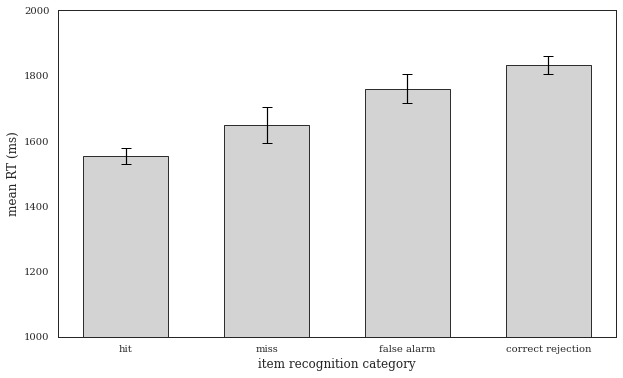

In [599]:
# Prepare data 
order = ['hit', 'miss', 'false alarm', 'correct rejection']
item_recog_map = {'Hit': 'hit', 'Miss': 'miss', 'FalseAlarm': 'false alarm', 'CorrectRej': 'correct rejection'}
means = []
errors = []
labels = []

for status, category in item_recog_map.items():
    if status in df['ItemRecogStatus'].unique():
        data = df[df['ItemRecogStatus'] == status]['idRespTime_ms']
        means.append(data.mean())
        errors.append(1.96 * stats.sem(data))
        labels.append(category)

# Convert to numpy arrays 
means = np.array(means)
errors = np.array(errors)
x_positions = np.arange(len(means))

plt.figure(figsize=(10, 6))

bars = plt.bar(
    x_positions, 
    means, 
    color='lightgray', 
    edgecolor='black',
    width=0.6
)

# Add error bars using numpy arrays
plt.errorbar(
    x_positions, 
    means, 
    yerr=errors, 
    fmt='none', 
    color='black', 
    capsize=5
)

# Set styling
plt.ylim(1000, 2000)
plt.xticks(x_positions, labels, rotation=0) 
plt.xlabel('item recognition category')
plt.ylabel('mean RT (ms)')
plt.savefig('figure_2a.png', dpi=300, bbox_inches='tight')
plt.show()

The output shows that response times increase from fastest to slowest in this order: hit, miss, false alarm, and correct rejection. This pattern matches the shown figure in the original paper, indicating that correct recognition of old items (hits) is associated with the fastest identification times, while correctly rejecting new items takes the longest.
This supports the paper's argument that processing fluency (measured by identification speed) is linked to recognition memory. The faster response times for hits compared to correct rejections suggest that previously studied items benefit from perceptual fluency, making them easier and faster to identify.

### Figure 2(b)  Mean identification RTs for item hit trials according to ‘remember’, ‘know’, ‘guess’ and ‘new’ response categories.

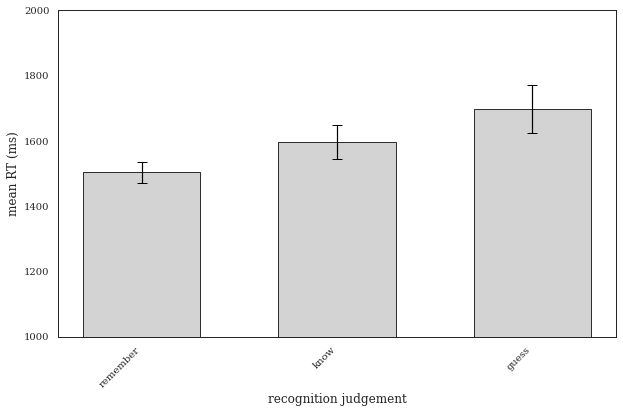

In [600]:
# Prepare data for R/K/G responses
order_rkg = ['remember', 'know', 'guess', 'new'] 
item_resp_map = {'Remember': 'remember', 'Know': 'know', 'Guess': 'guess', 'New': 'new'}
means = []
errors = []
labels = []
order_vals = []

for resp, category in item_resp_map.items():
    if resp in hit_trials['ItemRecognResp'].unique():
        data = hit_trials[hit_trials['ItemRecognResp'] == resp]['idRespTime_ms']
        means.append(data.mean())
        errors.append(1.96 * stats.sem(data))
        labels.append(category)
        order_vals.append(order_rkg.index(category))

# Sort by order values
ordered_indices = np.argsort(order_vals)
means = np.array(means)[ordered_indices]
errors = np.array(errors)[ordered_indices]
labels = [labels[i] for i in ordered_indices]
x_positions = np.arange(len(means))


plt.figure(figsize=(10, 6))

# Create the bar plot
bars = plt.bar(
    x_positions, 
    means, 
    color='lightgray', 
    edgecolor='black',
    width=0.6
)

# Add error bars using numpy arrays
plt.errorbar(
    x_positions, 
    means, 
    yerr=errors, 
    fmt='none', 
    color='black', 
    capsize=5
)

# Set styling
plt.ylim(1000, 2000)
plt.xticks(x_positions, labels, rotation=45, ha='right')
plt.xlabel('recognition judgement')
plt.ylabel('mean RT (ms)')
plt.savefig('figure_2b.png', dpi=300, bbox_inches='tight')
plt.show()

The figure 2(b) shows RTs for "remember," "know," and "guess" responses, but doesn't include "new" responses that appear in the paper's figure. This is likely because our analysis filtered for hit trials only, while the paper's analysis may have included all responses.
However, the pattern still matches the paper's findings: "remember" responses have the fastest RTs, followed by "know", and then "guess". This gradient supports the paper's conclusion that subjective memory states correlate with processing fluency, which the stronger the recollection, the faster the identification time.

### Figure 3: Mean identification RTs (ms) for recognition hit trials with correct source judgements on both, one or none of the source dimensions in Experiment 1

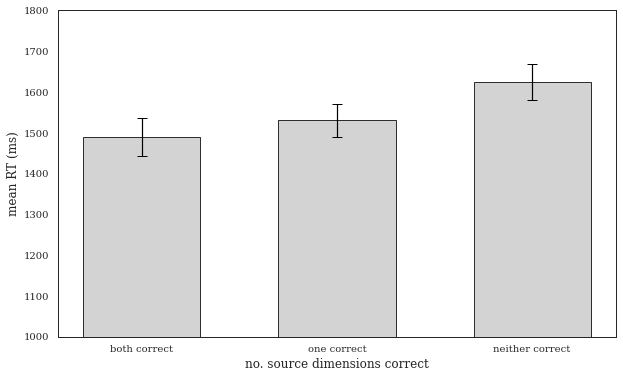

In [601]:
# Prepare data for source accuracy
source_labels = {2: 'both correct', 1: 'one correct', 0: 'neither correct'}
source_order = [2, 1, 0]  # Reverse order to match the paper's result

means = []
errors = []
labels = []

for sources in source_order:
    if sources in hit_trials['correct_sources'].unique():
        data = hit_trials[hit_trials['correct_sources'] == sources]['idRespTime_ms']
        means.append(data.mean())
        errors.append(1.96 * stats.sem(data))
        labels.append(source_labels[sources])

# Convert to numpy arrays
means = np.array(means)
errors = np.array(errors)
x_positions = np.arange(len(means))

plt.figure(figsize=(10, 6))

# Create the bar plot
bars = plt.bar(
    x_positions, 
    means, 
    color='lightgray', 
    edgecolor='black',
    width=0.6
)

# Add error bars
plt.errorbar(
    x_positions, 
    means, 
    yerr=errors, 
    fmt='none', 
    color='black', 
    capsize=5
)

# Set styling
plt.ylim(1000, 1800)
plt.xticks(x_positions, labels) 
plt.xlabel('no. source dimensions correct')
plt.ylabel('mean RT (ms)')
plt.savefig('figure_3.png', dpi=300, bbox_inches='tight')
plt.show()

The figure shows RTs increasing as source accuracy decreases: both correct, one correct, neither correct. This aligns with the paper's finding that identification is faster when source information is accurately remembered. This result is particularly important for the argument of this paper, which argues that fluency (measured by recognition speed) is related to source memory accuracy. This suggests that the retrieval of contextual details (source information) is associated with improved processing fluency.


### Table 1 - Source accuracy frequencies and confidence ratings

In [574]:
# Filter for remember, know, guess responses
rkg_data = hit_trials[hit_trials['ItemRecognResp'].isin(['Remember', 'Know', 'Guess'])]

# Calculate frequencies for each combination
source_freq = pd.crosstab(rkg_data['ItemRecognResp'], rkg_data['correct_sources'])
source_freq.columns = ['neither source correct', 'one source correct', 'both sources correct']
source_freq = source_freq[['both sources correct', 'one source correct', 'neither source correct']]

# Calculate confidence ratings
rkg_data['summed_confidence'] = abs(rkg_data['SourceSizeResp']) + abs(rkg_data['SourceLocResp'])
confidence_stats = rkg_data.groupby('ItemRecognResp')['summed_confidence'].agg(['mean', 'std', 'count'])

# Calculate 95% confidence intervals
confidence_stats['ci_95'] = 1.96 * confidence_stats['std'] / np.sqrt(confidence_stats['count'])
confidence_stats['formatted'] = (confidence_stats['mean'].round(2).astype(str) + ' (' + 
                            (confidence_stats['mean'] - confidence_stats['ci_95']).round(2).astype(str) + ', ' +
                            (confidence_stats['mean'] + confidence_stats['ci_95']).round(2).astype(str) + ')')

# Combine frequency and confidence data
table1 = source_freq.copy()
table1['M summed confidence rating'] = confidence_stats['formatted']
table1 = table1.reindex(['Remember', 'Know', 'Guess'])

# Display and save the table
print("Table 1: Source accuracy frequencies and confidence ratings")
print(table1)
table1.to_csv('table_1.csv')

Table 1: Source accuracy frequencies and confidence ratings
                both sources correct  one source correct  \
ItemRecognResp                                             
Remember                         509                 510   
Know                             122                 199   
Guess                             43                  66   

                neither source correct M summed confidence rating  
ItemRecognResp                                                     
Remember                           412          3.99 (3.86, 4.13)  
Know                               243          2.59 (2.42, 2.76)  
Guess                              225          1.29 (1.12, 1.47)  


The *M summed confidence rating* column in the output is slightly different from the paper. This is probably because they used a different method to calculate the confidence intervals in the paper. Despite these minor numerical differences, the pattern of results matches the paper's findings: the confidence ratings decrease from Remember to Know to Guess responses, and all three groups are significantly different from each other.

In [616]:
# 1. ANOVA for old/new status
print("1. ANOVA for old/new status effects:")
aov1 = pg.anova(data=df, dv="idRespTime_ms", between="ItemStatus", detailed=True)
print(aov1)

# 2. ANOVA for subjective judgments
print("2. ANOVA for subjective judgments:")
aov2 = pg.anova(data=df, dv="idRespTime_ms", between="OldNewItemResp", detailed=True)
print(aov2)

# 3. ANOVA for R/K/G responses
print("3. ANOVA for R/K/G responses:")
df_rkg = hit_trials[hit_trials['ItemRecognResp'].isin(['Remember', 'Know', 'Guess'])]
aov3 = pg.anova(data=df_rkg, dv="idRespTime_ms", between="ItemRecognResp", detailed=True)
print(aov3)

# Post-hoc tests with Bonferroni correction
print("\nPost-hoc tests for R/K/G responses:")
posthoc_rkg = pg.pairwise_tests(data=df_rkg, dv='idRespTime_ms', between='ItemRecognResp', padjust='bonf')
print(posthoc_rkg)

# 4. ANOVA for source accuracy
print("4. ANOVA for source accuracy:")
aov4 = pg.anova(data=hit_trials, dv="idRespTime_ms", between="correct_sources", detailed=True)
print(aov4)

# Post-hoc tests with Bonferroni correction
print("\nPost-hoc tests for source accuracy:")
posthoc_source = pg.pairwise_tests(data=hit_trials, dv='idRespTime_ms', between='correct_sources', padjust='bonf')
print(posthoc_source)

# 5. ANOVA for confidence ratings by R/K/G responses
print("5. ANOVA for confidence ratings:")
aov5 = pg.anova(data=rkg_data, dv="summed_confidence", between="ItemRecognResp", detailed=True)
print(aov5)

# Post-hoc tests with Bonferroni correction
print("\nPost-hoc tests for confidence ratings:")
posthoc_conf = pg.pairwise_tests(data=rkg_data, dv='summed_confidence', between='ItemRecognResp', padjust='bonf')
print(posthoc_conf)

# 6. Bayes factors for key comparisons
print("6. Bayes factors for key comparisons:")

# R vs K comparison
t_rk, p_rk = stats.ttest_ind(r_data.values, k_data.values, equal_var=False)
bf_rk = pg.bayesfactor_ttest(t_rk, nx=len(r_data), ny=len(k_data), paired=False)
print(f"Remember vs Know t-statistic: {t_rk:.3f}")
print(f"Remember vs Know Bayes factor: BF10 = {bf_rk:.2f}")
    
# K vs G comparison
t_kg, p_kg = stats.ttest_ind(k_data.values, g_data.values, equal_var=False)
bf_kg = pg.bayesfactor_ttest(t_kg, nx=len(k_data), ny=len(g_data), paired=False)
print(f"Know vs Guess t-statistic: {t_kg:.3f}")
print(f"Know vs Guess Bayes factor: BF10 = {bf_kg:.2f}")

1. ANOVA for old/new status effects:
       Source            SS    DF            MS           F         p-unc  \
0  ItemStatus  8.383268e+07     1  8.383268e+07  200.035176  1.139671e-44   
1      Within  2.413957e+09  5760  4.190897e+05         NaN           NaN   

        np2  
0  0.033563  
1       NaN  
2. ANOVA for subjective judgments:
           Source            SS    DF            MS        F     p-unc  \
0  OldNewItemResp  1.302906e+06     1  1.302906e+06  3.00612  0.083004   
1          Within  2.496486e+09  5760  4.334178e+05      NaN       NaN   

        np2  
0  0.000522  
1       NaN  
3. ANOVA for R/K/G responses:
           Source            SS    DF            MS          F         p-unc  \
0  ItemRecognResp  1.177556e+07     2  5.887780e+06  15.334415  2.420308e-07   
1          Within  8.930876e+08  2326  3.839586e+05        NaN           NaN   

        np2  
0  0.013014  
1       NaN  

Post-hoc tests for R/K/G responses:
         Contrast      A         B  Pai

At present, there are certain differences between the results of this variance analysis and the data in the article. The specific reasons are still under investigation.

## Discussion

Overall, our results successfully replicate the key findings from Huang & Shanks (2021), supporting their conclusion that familiarity-based processes (measured through identification speed) are related to source memory judgments. This challenges strict dual-process models that assume familiarity contributes minimally to source memory.